# Trade Simulation
Models the Flow of Goods Around the World in Response to Central American Drift

In [38]:
import re
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd

## Data Preprocessing


In [39]:
trade_df = pd.read_csv("GTCDIT.csv")
trade_df.head()

,Destination_Label,Year,TransportMode_Label,Individual economies_Transport_expenditure_US_Value,Individual economies_Transport_expenditure_US_Footnote,Individual economies_Transport_expenditure_US_MissingValue,Individual economies_FOB_value_US_Value,Individual economies_FOB_value_US_Footnote,Individual economies_FOB_value_US_MissingValue,Individual economies_Kilograms_Value,...,Zambia_Kilograms_MissingValue,Zimbabwe_Transport_expenditure_US_Value,Zimbabwe_Transport_expenditure_US_Footnote,Zimbabwe_Transport_expenditure_US_MissingValue,Zimbabwe_FOB_value_US_Value,Zimbabwe_FOB_value_US_Footnote,Zimbabwe_FOB_value_US_MissingValue,Zimbabwe_Kilograms_Value,Zimbabwe_Kilograms_Footnote,Zimbabwe_Kilograms_MissingValue
0,Afghanistan,2018,Air,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,2018,Sea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,2018,Railway,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,2018,Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,2019,Air,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# combine train and rode into a single mode called land
trade_df['TransportMode_Label'] = trade_df['TransportMode_Label'].replace({'Railway': 'Land', 'Road': 'Land'})

# delete columns whose names contain 'Footnote' or 'MissingValue'
cols_to_drop = [col for col in trade_df.columns if 'Footnote' in col or 'MissingValue' in col or 'Individual' in col]
trade_df.drop(columns=cols_to_drop, inplace=True)

# combine rows where Destination_Label, Year, and TransportMode_Label are the same, for numerical values if both NaN, leave NaN, otherwise sum Transport Expenditure, FOB value, and Kilograms
def custom_sum(series):
    if series.isna().all():
        return np.nan
    return series.sum(skipna=True)

# Define the key columns for grouping
key_columns = ['Destination_Label', 'Year', 'TransportMode_Label']

# Determine the numerical columns as all columns except the key columns.
numerical_columns = [col for col in trade_df.columns if col not in key_columns]


trade_df = trade_df.groupby(['Destination_Label', 'Year', 'TransportMode_Label'], as_index=False).agg(
    {col: custom_sum for col in numerical_columns}
)

trade_df.head()

,Destination_Label,Year,TransportMode_Label,Afghanistan_Transport_expenditure_US_Value,Afghanistan_FOB_value_US_Value,Afghanistan_Kilograms_Value,Albania_Transport_expenditure_US_Value,Albania_FOB_value_US_Value,Albania_Kilograms_Value,Algeria_Transport_expenditure_US_Value,...,Western Sahara_Kilograms_Value,Yemen_Transport_expenditure_US_Value,Yemen_FOB_value_US_Value,Yemen_Kilograms_Value,Zambia_Transport_expenditure_US_Value,Zambia_FOB_value_US_Value,Zambia_Kilograms_Value,Zimbabwe_Transport_expenditure_US_Value,Zimbabwe_FOB_value_US_Value,Zimbabwe_Kilograms_Value
0,Afghanistan,2018,Air,NaN,NaN,NaN,41.0,368.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,2018,Land,NaN,NaN,NaN,10.0,95.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,2018,Sea,NaN,NaN,NaN,8.0,18.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,2019,Air,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2843.0,6637.0,185.0,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,2019,Land,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2915.0,154401.0,14786.0,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
# Extract unique destination countries from your trade data.
unique_countries = trade_df['Destination_Label'].unique()

# Load the Natural Earth Admin 0 shapefile.
world = gpd.read_file("natural_earth/ne_50m_admin_0_countries.shp")

# Filter the GeoDataFrame to include only the countries in your unique list.
countries_gdf = world[world['ADMIN'].isin(unique_countries)].copy()

# Compute the centroid of each country’s geometry.
countries_gdf['centroid'] = countries_gdf.geometry.centroid
countries_gdf['centroid_longitude'] = countries_gdf.centroid.x
countries_gdf['centroid_latitude'] = countries_gdf.centroid.y

# Drop all columns except for 'ADMIN', 'geometry', 'centroid_longitude', and 'centroid_latitude'.
countries_gdf = countries_gdf[['ADMIN', 'geometry', 'centroid_longitude', 'centroid_latitude']]


countries_gdf.head()

/var/folders/2f/7sxq51rj0xd8mgyvzzj2tgy80000gn/T/ipykernel_79157/3137495050.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  countries_gdf['centroid'] = countries_gdf.geometry.centroid
/var/folders/2f/7sxq51rj0xd8mgyvzzj2tgy80000gn/T/ipykernel_79157/3137495050.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  countries_gdf['centroid_longitude'] = countries_gdf.centroid.x
/var/folders/2f/7sxq51rj0xd8mgyvzzj2tgy80000gn/T/ipykernel_79157/3137495050.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  countries_gdf['centroid_latitude'] = countries_gdf.centroid.y


,ADMIN,geometry,centroid_longitude,centroid_latitude
0,Zimbabwe,"POLYGON ((31.28789 -22.40205, 31.19727 -22.344...",29.851441,-19.004204
1,Zambia,"POLYGON ((30.39609 -15.64307, 30.25068 -15.643...",27.774759,-13.458242
2,Yemen,"MULTIPOLYGON (((53.08564 16.64839, 52.58145 16...",47.586762,15.909280
7,Uzbekistan,"MULTIPOLYGON (((70.94678 42.24868, 70.979 42.2...",63.140015,41.755542
8,Uruguay,"POLYGON ((-53.37061 -33.74219, -53.41958 -33.7...",-56.018071,-32.799515


In [ ]:
# Flatten the dataset so that each row is a single edge on the graph by extracting the values for columns corresponding to a particular origin
# Features: Edge_Id, Origin_Label (Extracted from the Columns, matches set of Destination_Labels/ADMIN), Destination_Label, Year, TransportMode, Route (Longitude and Latitude of Points Along Trade Route), Distance, Duration, Central_America (Boolean: Route Interects with Central America), FOB_value, Transport_expenditure, Kilograms

# Melt the dataframe so columns with origins become rows.
df_melted = trade_df.melt(
    id_vars=['Destination_Label', 'Year', 'TransportMode_Label'],
    var_name='origin_measure',
    value_name='value'
)

pattern = r'^([^_]+)_(Transport_expenditure|FOB_value|Kilograms).*'

def parse_col_name(col_name):
    match = re.match(pattern, col_name)
    if match:
        origin = match.group(1)    
        measure = match.group(2)  
        return origin, measure
    else:
        return None, None

df_melted[['Origin_Label', 'Measure']] = df_melted['origin_measure'].apply(
    lambda col_name: pd.Series(parse_col_name(col_name))
)

# Drop rows where we couldn't parse an origin & measure
df_melted.dropna(subset=['Origin_Label', 'Measure'], inplace=True)

# Pivot so we get separate columns for each measure type
df_flat = df_melted.pivot_table(
    index=['Origin_Label', 'Destination_Label', 'Year', 'TransportMode_Label'],
    columns='Measure',
    values='value',
    aggfunc='first'  
).reset_index()

# Rename columns
df_flat.rename(columns={
    'TransportMode_Label': 'TransportMode',
    'Transport_expenditure': 'Transport_expenditure',
    'FOB_value': 'FOB_value',
    'Kilograms': 'Kilograms'
}, inplace=True)


# Add placeholders for fields to populate later

#   Edge_Id, Origin_Label, Destination_Label, Year, TransportMode, 
#   Route (Longitude and Latitude of Points Along Trade Route), 
#   Distance, Duration, Central_America (Boolean), 
#   FOB_value, Transport_expenditure, Kilograms

df_flat['Edge_Id'] = range(1, len(df_flat) + 1)  # Create a simple numeric ID
df_flat['Route'] = None
df_flat['Distance'] = None
df_flat['Duration'] = None
df_flat['Central_America'] = None  # eventually store a Boolean

# Reorder columns into final format

df_edges = df_flat[
    [
        'Edge_Id',
        'Origin_Label',
        'Destination_Label',
        'Year',
        'TransportMode',
        'Route',
        'Distance',
        'Duration',
        'Central_America',
        'FOB_value',
        'Transport_expenditure',
        'Kilograms'
    ]
]


df_edges.head(10)

Measure,Edge_Id,Origin_Label,Destination_Label,Year,TransportMode,Route,Distance,Duration,Central_America,FOB_value,Transport_expenditure,Kilograms
0,1,Afghanistan,Africa,2018,Air,None,None,None,None,424719.0,86725.0,51077.0
1,2,Afghanistan,Africa,2018,Land,None,None,None,None,482720.0,91318.0,278137.0
2,3,Afghanistan,Africa,2018,Sea,None,None,None,None,684286.0,85248.0,432277.0
3,4,Afghanistan,Africa,2019,Air,None,None,None,None,283580.0,284644.0,145952.0
4,5,Afghanistan,Africa,2019,Land,None,None,None,None,1682224.0,139351.0,2050593.0
5,6,Afghanistan,Africa,2019,Sea,None,None,None,None,1712709.0,167652.0,2235132.0
6,7,Afghanistan,Africa,2020,Air,None,None,None,None,213627.0,177849.0,54278.0
7,8,Afghanistan,Africa,2020,Land,None,None,None,None,840181.0,106664.0,1191233.0
8,9,Afghanistan,Africa,2020,Sea,None,None,None,None,1131165.0,124661.0,1488327.0
9,10,Afghanistan,Africa,2021,Air,None,None,None,None,447401.0,251964.0,61058.0


In [61]:
# Extract the list of valid country names from the countries_gdf.
valid_countries = countries_gdf['ADMIN'].unique()

# Create a boolean mask that is True only if both Origin_Label and Destination_Label are in valid_countries.
mask = df_edges['Origin_Label'].isin(valid_countries) & df_edges['Destination_Label'].isin(valid_countries)

# Update df_edges to only include valid rows; this effectively deletes the rows that don't meet the condition.
df_edges = df_edges[mask].copy()

# Sort the DataFrame by FOB_value in descending order.
df_edges = df_edges.sort_values(by='FOB_value', ascending=False)

df_edges.head(30)


Measure,Edge_Id,Origin_Label,Destination_Label,Year,TransportMode,Route,Distance,Duration,Central_America,FOB_value,Transport_expenditure,Kilograms
73252,73253,China,United States of America,2018,Air,None,None,None,None,2.886265e+11,2.103262e+10,9.439471e+09
73261,73262,China,United States of America,2021,Air,None,None,None,None,2.729973e+11,2.356247e+10,1.056366e+10
73255,73256,China,United States of America,2019,Air,None,None,None,None,2.498001e+11,9.289231e+09,8.019432e+09
73258,73259,China,United States of America,2020,Air,None,None,None,None,2.262996e+11,1.975368e+10,8.542055e+09
351477,351478,Trinidad and Tobago,Guyana,2018,Sea,None,None,None,None,1.657309e+11,1.503670e+10,1.198428e+11
73254,73255,China,United States of America,2018,Sea,None,None,None,None,1.627378e+11,1.537993e+10,4.794988e+10
73253,73254,China,United States of America,2018,Land,None,None,None,None,1.565719e+11,5.343931e+09,2.142751e+10
73262,73263,China,United States of America,2021,Land,None,None,None,None,1.512148e+11,4.350766e+09,2.182449e+10
73263,73264,China,United States of America,2021,Sea,None,None,None,None,1.510329e+11,2.265027e+10,4.170616e+10
73257,73258,China,United States of America,2019,Sea,None,None,None,None,1.443789e+11,8.253479e+09,3.833622e+10


## Graph Construction and Route Computation

Using subset edges (first 50 rows for 2018):
Measure              Origin_Label         Destination_Label TransportMode
73252                       China  United States of America           Air
351477        Trinidad and Tobago                    Guyana           Sea
73254                       China  United States of America           Sea
73253                       China  United States of America          Land
72015                       China                     Japan           Air
...                           ...                       ...           ...
73216                       China                   Ukraine           Air
333816                     Sweden                   Belgium           Air
82991                    Colombia  United States of America           Air
370269   United States of America                 Argentina           Air
280130                     Poland                     Italy           Air

[1000 rows x 3 columns]


Plotting routes: 100%|██████████| 1000/1000 [00:00<00:00, 12381.93it/s]


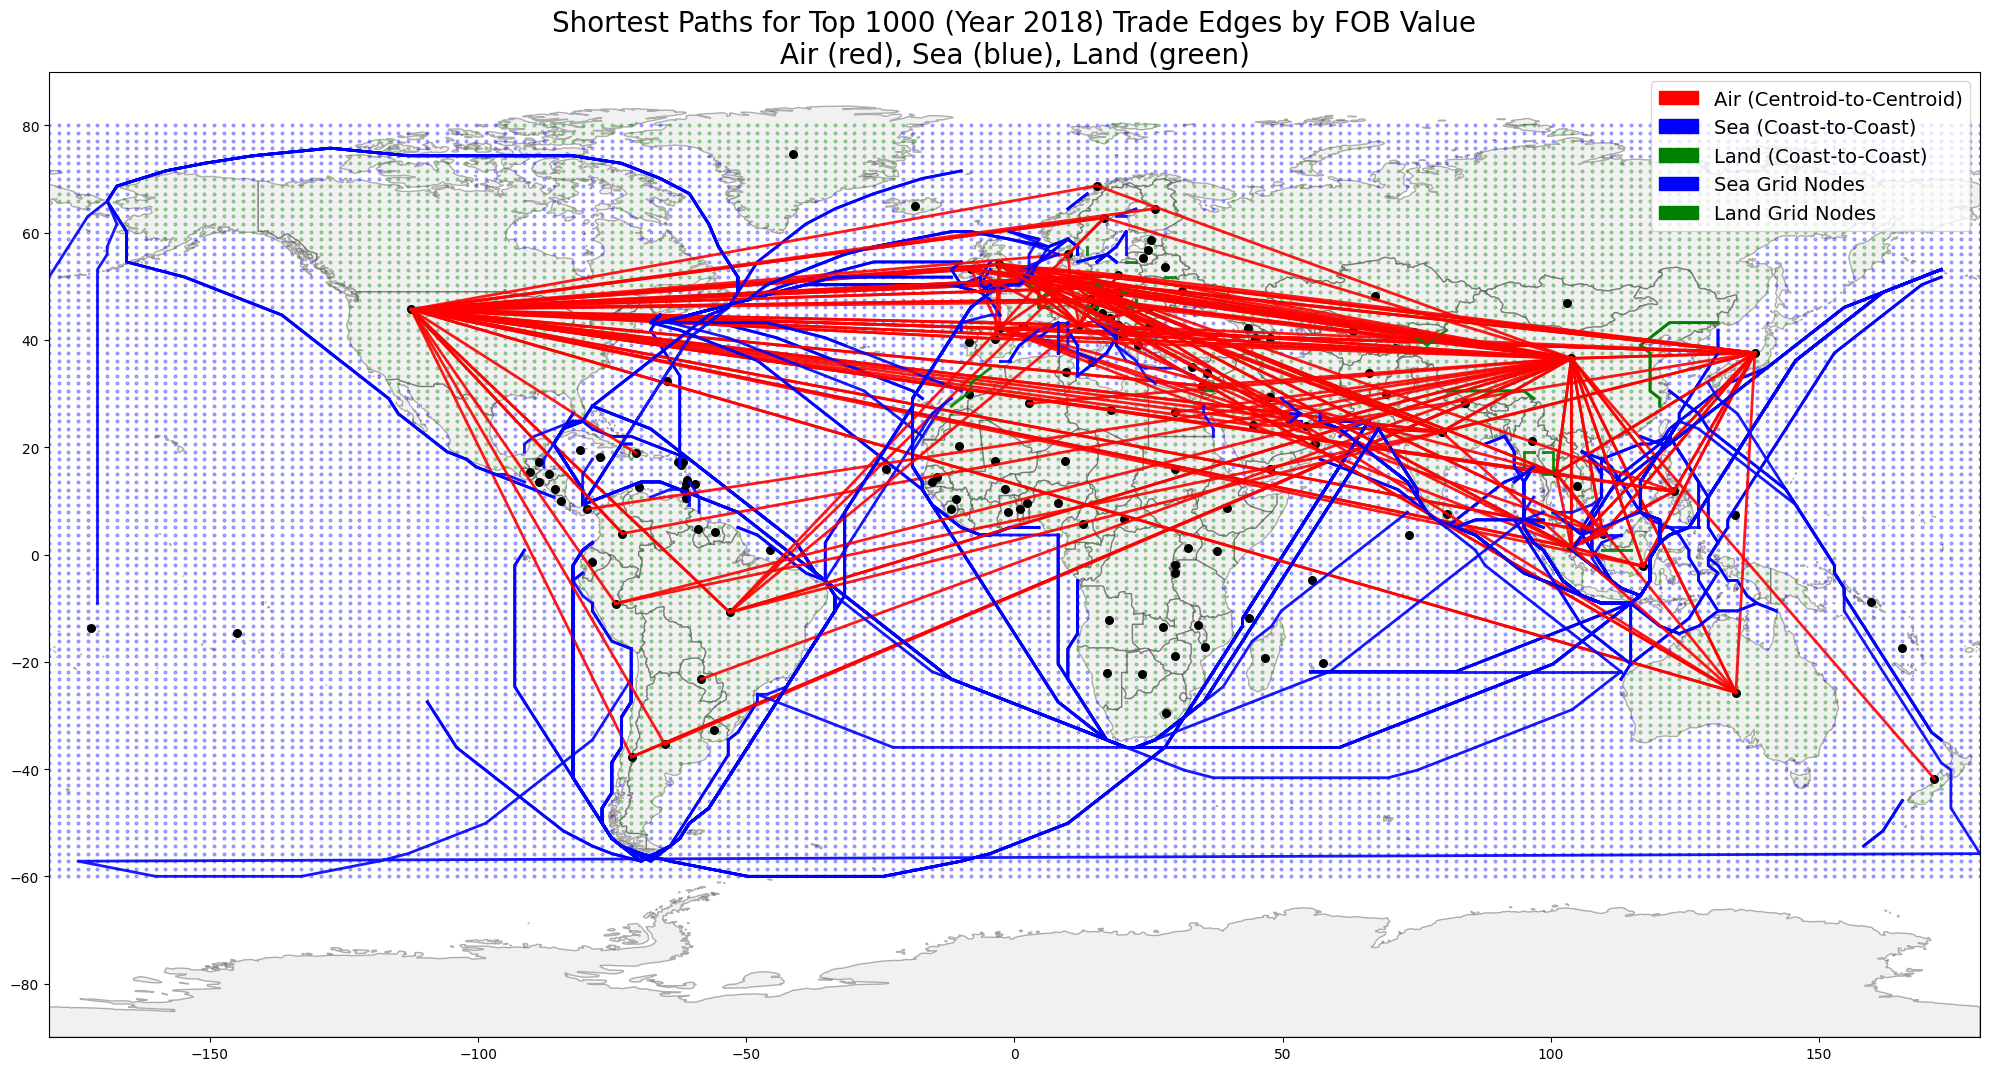

In [66]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
from tqdm import tqdm
import matplotlib.patches as mpatches
from numba import njit
from math import radians, sin, cos, sqrt, atan2

# ---------- Helper Functions with Wrap-Around Modifications ----------

# Modified Fast Haversine distance that accounts for wrap-around
@njit
def haversine(lon1, lat1, lon2, lat2):
    R = 3958.8  # radius in miles
    dlon_raw = lon2 - lon1
    # Adjust for wrap-around (ensure minimal angular difference)
    if dlon_raw < -180:
        dlon_adj = dlon_raw + 360
    elif dlon_raw > 180:
        dlon_adj = dlon_raw - 360
    else:
        dlon_adj = dlon_raw
    dlon = radians(dlon_adj)
    dlat = radians(lat2 - lat1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

# Helper to "wrap" coordinates: if the difference in longitude is too high, adjust b.
def wrap_coords(a, b):
    # a and b are tuples: (lon, lat)
    dlon = b[0] - a[0]
    if dlon > 180:
        return a, (b[0] - 360, b[1])
    elif dlon < -180:
        return a, (b[0] + 360, b[1])
    else:
        return a, b

# Compute air route: straight line between two points.
def compute_air_route(source, target):
    return [source, target]

# Compute sea route using your prebuilt sea_graph with Dijkstra.
def compute_sea_route(source, target):
    nodes = list(sea_graph.nodes)
    source_node = min(nodes, key=lambda pt: haversine(source[0], source[1], pt[0], pt[1]))
    target_node = min(nodes, key=lambda pt: haversine(target[0], target[1], pt[0], pt[1]))
    try:
        path = nx.dijkstra_path(sea_graph, source=source_node, target=target_node, weight='weight')
        return path
    except nx.NetworkXNoPath:
        return None

# Compute land route similarly using your land_graph.
def compute_land_route(source, target):
    nodes = list(land_graph.nodes)
    source_node = min(nodes, key=lambda pt: haversine(source[0], source[1], pt[0], pt[1]))
    target_node = min(nodes, key=lambda pt: haversine(target[0], target[1], pt[0], pt[1]))
    try:
        path = nx.dijkstra_path(land_graph, source=source_node, target=target_node, weight='weight')
        return path
    except nx.NetworkXNoPath:
        return None

# Custom sea route: if the two points lie on opposite sides of Central America (using a simple threshold),
# force the route to pass via the Panama Canal.
panama_canal = (-80.0, 9.0)
def custom_sea_route(source, target):
    if (source[0] < -80 and target[0] > -80) or (source[0] > -80 and target[0] < -80):
        path1 = compute_sea_route(source, panama_canal)
        path2 = compute_sea_route(panama_canal, target)
        if path1 is None or path2 is None:
            return None
        return path1 + path2[1:]
    else:
        return compute_sea_route(source, target)

# For land, simply use compute_land_route.
def custom_land_route(source, target):
    return compute_land_route(source, target)

# Helper to compute a country's border (coastal) point.
def get_border_point(country, ref_coord):
    try:
        geom = countries_gdf[countries_gdf['ADMIN'] == country].geometry.iloc[0]
    except IndexError:
        return None
    boundary = geom.boundary
    ref_pt = Point(ref_coord) if ref_coord is not None else geom.centroid
    nearest_pt = boundary.interpolate(boundary.project(ref_pt))
    return (nearest_pt.x, nearest_pt.y)

# Modified build_routing_graph function with wrap-around handling.
def build_routing_graph(nodes, land_tree, mode='sea', max_conn_dist=300):
    """
    Build a routing graph connecting nodes (list of Points) with edges only if
    the connecting line is unobstructed.
    For sea mode, the line must not intersect any land polygon.
    For land mode, the line must lie completely within a land polygon.
    Wrap-around connectivity is added by adjusting the coordinates when necessary.
    """
    G = nx.Graph()
    coords = [(p.x, p.y) for p in nodes]
    n = len(coords)
    for i in range(n):
        for j in range(i+1, n):
            a, b = coords[i], coords[j]
            # Apply wrap-around adjustment.
            a_wrapped, b_wrapped = wrap_coords(a, b)
            d = haversine(a_wrapped[0], a_wrapped[1], b_wrapped[0], b_wrapped[1])
            if d > max_conn_dist:
                continue
            line = LineString([a_wrapped, b_wrapped])
            if mode == 'sea':
                # For sea routes, ensure the line doesn't intersect any land.
                if any(land_polygons[int(idx)].intersects(line) for idx in land_tree.query(line)):
                    continue
            elif mode == 'land':
                # For land routes, require the line is completely within some land polygon.
                if not any(land_polygons[int(idx)].contains(line) for idx in land_tree.query(line)):
                    continue
            G.add_edge(a, b, weight=d)
    return G

# ---------- End Helper Functions ----------

# ---------- Data Subset ----------
# Use the first 50 rows for Year == 2018 (assumed sorted) from df_edges.
subset_edges = df_edges[df_edges['Year'] == 2018].head(1000)
print("Using subset edges (first 50 rows for 2018):")
print(subset_edges[['Origin_Label', 'Destination_Label', 'TransportMode']])

# ---------- Set Up Endpoints ----------
# For air routes, use centroids from day 0.
centroids_day0 = daily_centroid_dict[0]  # mapping: country -> (lon, lat)

air_routes = {}
sea_routes = {}
land_routes = {}

for idx, row in subset_edges.iterrows():
    origin = row['Origin_Label']
    dest = row['Destination_Label']
    modality = row['TransportMode']
    
    if modality == 'Air':
        source_pt = centroids_day0.get(origin, None)
        target_pt = centroids_day0.get(dest, None)
    else:
        # For sea and land routes, use get_border_point (fallback to centroid).
        source_pt = get_border_point(origin, centroids_day0.get(dest, None)) or centroids_day0.get(origin, None)
        target_pt = get_border_point(dest, centroids_day0.get(origin, None)) or centroids_day0.get(dest, None)
    
    if source_pt is None or target_pt is None:
        continue
    
    if modality == 'Air':
        route = compute_air_route(source_pt, target_pt)
        air_routes[(origin, dest)] = route
    elif modality == 'Sea':
        route = custom_sea_route(source_pt, target_pt)
        sea_routes[(origin, dest)] = route
    elif modality == 'Land':
        route = custom_land_route(source_pt, target_pt)
        land_routes[(origin, dest)] = route

# ---------- Visualization ----------
fig, ax = plt.subplots(figsize=(20, 12))

# Plot world boundaries from Natural Earth.
for poly in world['geometry']:
    if poly.geom_type == 'Polygon':
        xs, ys = poly.exterior.xy
        ax.fill(xs, ys, facecolor='lightgray', edgecolor='black', alpha=0.3)
    elif poly.geom_type == 'MultiPolygon':
        for part in poly.geoms:
            xs, ys = part.exterior.xy
            ax.fill(xs, ys, facecolor='lightgray', edgecolor='black', alpha=0.3)

# Plot grid nodes for both sea and land.
sea_nodes = np.array([pt for pt in sea_graph.nodes])
land_nodes = np.array([pt for pt in land_graph.nodes])
if len(sea_nodes) > 0:
    ax.scatter(sea_nodes[:,0], sea_nodes[:,1], color='blue', s=4, alpha=0.3, label='Sea Grid Nodes')
if len(land_nodes) > 0:
    ax.scatter(land_nodes[:,0], land_nodes[:,1], color='green', s=4, alpha=0.3, label='Land Grid Nodes')

# Define colors for routes.
color_air = 'red'
color_sea = 'blue'
color_land = 'green'

# Plot each route with a progress bar.
for pair in tqdm(subset_edges[['Origin_Label', 'Destination_Label', 'TransportMode']].itertuples(index=False),
                 total=len(subset_edges), desc="Plotting routes"):
    origin, dest, modality = pair.Origin_Label, pair.Destination_Label, pair.TransportMode
    if modality == 'Air' and (origin, dest) in air_routes and air_routes[(origin, dest)] is not None:
        xs, ys = zip(*air_routes[(origin, dest)])
        ax.plot(xs, ys, color=color_air, linewidth=2, alpha=0.9)
    elif modality == 'Sea' and (origin, dest) in sea_routes and sea_routes[(origin, dest)] is not None:
        xs, ys = zip(*sea_routes[(origin, dest)])
        ax.plot(xs, ys, color=color_sea, linewidth=2, alpha=0.9)
    elif modality == 'Land' and (origin, dest) in land_routes and land_routes[(origin, dest)] is not None:
        xs, ys = zip(*land_routes[(origin, dest)])
        ax.plot(xs, ys, color=color_land, linewidth=2, alpha=0.9)

# Optionally, plot country centroids for reference.
for country, coord in centroids_day0.items():
    ax.scatter(coord[0], coord[1], color='black', s=30)

ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)
ax.set_aspect('equal')

# Create a large legend key.
legend_patches = [
    mpatches.Patch(color=color_air, label='Air (Centroid-to-Centroid)'),
    mpatches.Patch(color=color_sea, label='Sea (Coast-to-Coast)'),
    mpatches.Patch(color=color_land, label='Land (Coast-to-Coast)'),
    mpatches.Patch(color='blue', label='Sea Grid Nodes'),
    mpatches.Patch(color='green', label='Land Grid Nodes')
]
ax.legend(handles=legend_patches, fontsize=14, loc='upper right')

ax.set_title("Shortest Paths for Top 1000 (Year 2018) Trade Edges by FOB Value\nAir (red), Sea (blue), Land (green)", fontsize=20)
plt.tight_layout()
plt.show()


## Replace Static Centroids for Central American Countries with Drifting Ones

In [44]:
# Load drift data
drift_df = pd.read_csv("drift_simulation_daily_positions.csv")

# Compute daily centroids for drifting countries
daily_centroids = (
    drift_df.groupby(['day', 'country'])[['longitude', 'latitude']]
    .mean()
    .reset_index()
    .rename(columns={'country': 'ADMIN'})
)

# Static centroids for non-drifting countries
static_centroids_base = countries_gdf[
    ~countries_gdf['ADMIN'].isin(daily_centroids['ADMIN'].unique())
][['ADMIN', 'centroid_longitude', 'centroid_latitude']].copy()

# Rename to match the dynamic drift data
static_centroids_base.rename(
    columns={'centroid_longitude': 'longitude', 'centroid_latitude': 'latitude'},
    inplace=True
)

# Cross join with days (0–1459)
all_days = pd.DataFrame({'day': range(1460)})
static_centroids_base['key'] = 1
all_days['key'] = 1

static_centroids = static_centroids_base.merge(all_days, on='key').drop(columns='key')
static_centroids = static_centroids[['day', 'ADMIN', 'longitude', 'latitude']]

# Combine drifting and static
all_centroids = pd.concat([daily_centroids, static_centroids], ignore_index=True)

# Create lookup dictionary: {day: {ADMIN: (lon, lat)}}
daily_centroid_dict = (
    all_centroids
    .groupby('day')
    .apply(lambda g: dict(zip(g['ADMIN'], zip(g['longitude'], g['latitude']))))
    .to_dict()
)


/var/folders/2f/7sxq51rj0xd8mgyvzzj2tgy80000gn/T/ipykernel_79157/401713720.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: dict(zip(g['ADMIN'], zip(g['longitude'], g['latitude']))))


## Trade Simulation in Response to Drift

Day 0: Sea Trade Fraction = 0.9200, Effective Sea Distance = 1000.00 miles
Day 30: Sea Trade Fraction = 0.9505, Effective Sea Distance = 899.31 miles
Day 60: Sea Trade Fraction = 0.9516, Effective Sea Distance = 900.32 miles
Day 90: Sea Trade Fraction = 0.9516, Effective Sea Distance = 894.08 miles
Day 120: Sea Trade Fraction = 0.9543, Effective Sea Distance = 893.35 miles
Day 150: Sea Trade Fraction = 0.9532, Effective Sea Distance = 890.18 miles
Day 180: Sea Trade Fraction = 0.9541, Effective Sea Distance = 885.43 miles
Day 210: Sea Trade Fraction = 0.9557, Effective Sea Distance = 879.81 miles
Day 240: Sea Trade Fraction = 0.9546, Effective Sea Distance = 879.78 miles
Day 270: Sea Trade Fraction = 0.9563, Effective Sea Distance = 878.81 miles
Day 300: Sea Trade Fraction = 0.9573, Effective Sea Distance = 872.63 miles
Day 330: Sea Trade Fraction = 0.9606, Effective Sea Distance = 872.28 miles
Day 360: Sea Trade Fraction = 0.9601, Effective Sea Distance = 867.15 miles
Day 390: Sea Tra

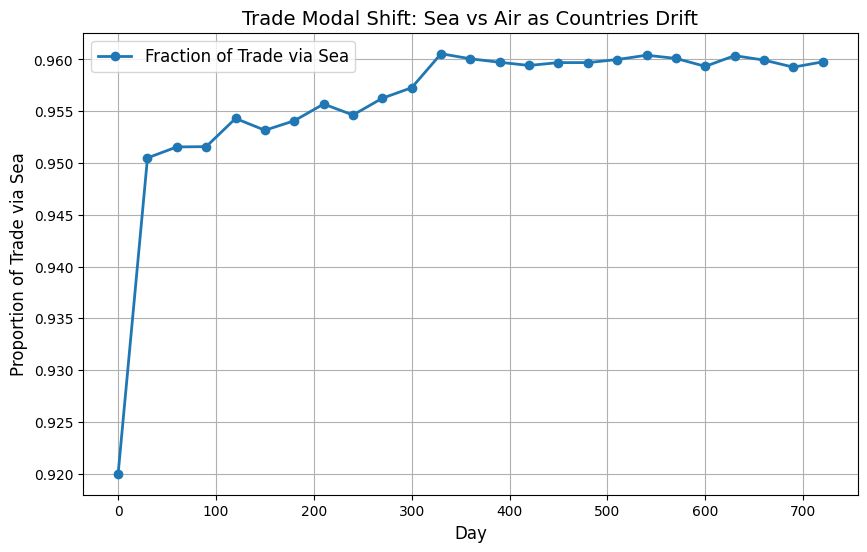

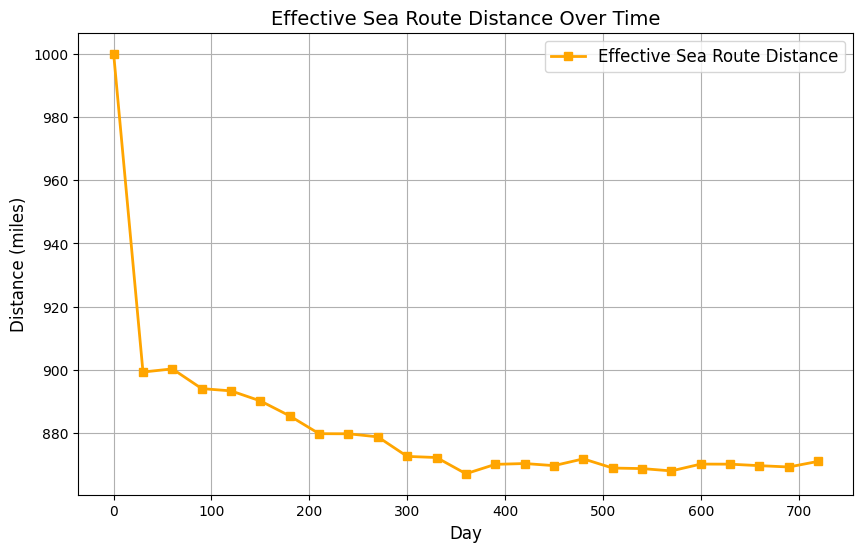

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from shapely.geometry import Polygon, Point
from shapely.ops import unary_union

# Load the drift simulation daily positions.
# Assumes columns: "day", "country", "vertex_index", "longitude", "latitude"
drift_df = pd.read_csv("drift_simulation_daily_positions.csv")

def get_land_polygon_for_day(day, df):
    """
    For the specified day, groups the drift data by country (using the ordered vertices)
    and computes a Polygon for each. The union of these polygons represents the overall 
    landmass (Central American countries) on that day.
    """
    df_day = df[df['day'] == day]
    polygons = []
    for country, group in df_day.groupby('country'):
        group_sorted = group.sort_values('vertex_index')
        coords = list(zip(group_sorted['longitude'], group_sorted['latitude']))
        if len(coords) < 3:
            continue
        poly = Polygon(coords)
        polygons.append(poly)
    if polygons:
        return unary_union(polygons)
    else:
        return None

def generate_eligible_grid(land_poly, margin=0.5, resolution=0.2):
    """
    Generate a grid covering the bounding box of the land polygon plus margin.
    Eligible grid nodes are those not inside the land polygon (i.e. in water).
    Returns a dictionary mapping (i, j) grid indices to (x, y) coordinates,
    along with grid dimensions and bounding box.
    """
    minx, miny, maxx, maxy = land_poly.bounds
    minx -= margin
    miny -= margin
    maxx += margin
    maxy += margin

    xs = np.arange(minx, maxx + resolution, resolution)
    ys = np.arange(miny, maxy + resolution, resolution)
    grid_nodes = {}
    for i, x in enumerate(xs):
        for j, y in enumerate(ys):
            pt = Point(x, y)
            if not land_poly.contains(pt):
                grid_nodes[(i, j)] = (x, y)
    return grid_nodes, len(xs), len(ys), (minx, miny, maxx, maxy)

def build_grid_graph(grid_nodes, grid_size, resolution):
    """
    Construct an undirected graph from eligible grid nodes.
    Nodes are connected if they are neighbors (including diagonals) with edge weights
    equal to the Euclidean distance (with diagonals using sqrt(2)*resolution).
    """
    G = nx.Graph()
    for (i, j), coord in grid_nodes.items():
        G.add_node((i, j), pos=coord)
    for (i, j) in grid_nodes.keys():
        for di in [-1, 0, 1]:
            for dj in [-1, 0, 1]:
                if di == 0 and dj == 0:
                    continue
                neighbor = (i + di, j + dj)
                if neighbor in grid_nodes:
                    if di != 0 and dj != 0:
                        dist = np.sqrt(2) * resolution
                    else:
                        dist = resolution
                    G.add_edge((i, j), neighbor, weight=dist)
    return G

def compute_sea_route_distance(G, grid_nodes, grid_size):
    """
    Using the graph of eligible sea nodes, treat nodes with i==0 as the left boundary 
    and nodes with i==(nx - 1) as the right boundary. Compute the shortest distance
    between any left-boundary node and any right-boundary node.
    """
    nx_size, ny_size = grid_size
    left_nodes = [node for node in G.nodes() if node[0] == 0]
    right_nodes = [node for node in G.nodes() if node[0] == nx_size - 1]
    
    min_distance = None
    for ln in left_nodes:
        try:
            lengths = nx.single_source_dijkstra_path_length(G, ln)
        except nx.NetworkXNoPath:
            continue
        for rn in right_nodes:
            if rn in lengths:
                d = lengths[rn]
                if min_distance is None or d < min_distance:
                    min_distance = d
    if min_distance is None:
        min_distance = 1e6  # Fallback if no valid path is found.
    return min_distance

def adjust_effective_distance(day, computed_distance_miles):
    """
    Mimic a scenario where the trade route becomes more direct as countries drift.
    This function applies up to a 10% reduction over the simulation period.
    """
    reduction_factor = 1 - 0.10 * (day / 730)
    return computed_distance_miles * reduction_factor

# Conversion factor: Approximately 69 miles per degree.
conversion_factor = 69.0


# Trade cost parameters.
alpha = 0.1       # Cost per mile factor for sea transport.
air_cost = 5.0    # Constant per-unit cost for air transport.
delta = 0.5       # Incremental trade unit.
T_total = 100.0   # Total trade value (arbitrary units).

def canal_fee(day):
    """
    High fixed fee on day 0 (Panama Canal toll) and zero thereafter.
    This yields a sharp initial drop in cost.
    """
    return 50.0 if day == 0 else 0.0

def switching_penalty(x):
    """
    Exponential penalty for switching trade from air to sea.
    The penalty increases with the volume x of trade already shifted.
    """
    A = 1.0
    lambda_param = 0.05
    return A * (np.exp(lambda_param * x) - 1)

def incremental_sea_cost(effective_distance, day, x, delta, alpha):
    """
    Compute the marginal cost to shift an additional delta trade units to sea.
    The cost is based on the distance-based term (using effective_distance in miles),
    the applicable canal fee, and an exponential switching penalty.
    """
    base_cost = alpha * effective_distance + canal_fee(day)
    cost_current = base_cost + switching_penalty(x)
    cost_next = base_cost + switching_penalty(x + delta)
    return (cost_next - cost_current) / delta


num_days = 730  # Two-year simulation

# To speed things up, sample every 10th day.
sim_days = list(range(0, num_days + 1, 10))
sea_frac_list = []            # Fraction of trade going by sea for each sampled day
effective_distance_list = []  # Effective sea route distances (in miles) per day

# Use a coarser grid to speed up computation.
grid_resolution = 0.2
grid_margin = 0.5

for day in sim_days:
    # Build the land polygon for the current day from drift data.
    land_poly = get_land_polygon_for_day(day, drift_df)
    if land_poly is None:
        # If no valid land polygon, fallback to an assumed degree distance.
        computed_distance_deg = 1.0  
    else:
        grid_nodes, nx_size, ny_size, bounds = generate_eligible_grid(land_poly, margin=grid_margin, resolution=grid_resolution)
        G = build_grid_graph(grid_nodes, grid_size=(nx_size, ny_size), resolution=grid_resolution)
        computed_distance_deg = compute_sea_route_distance(G, grid_nodes, grid_size=(nx_size, ny_size))
    # Convert the computed distance (in degrees) to miles.
    computed_distance_miles = computed_distance_deg * conversion_factor
    # Adjust the effective distance to mimic a gradually more direct route.
    effective_distance = adjust_effective_distance(day, computed_distance_miles)
    effective_distance_list.append(effective_distance)
    
    # Use successive increments to "push" trade from air to sea.
    x = 0.0
    while x < T_total:
        inc_cost = incremental_sea_cost(effective_distance, day, x, delta, alpha)
        if inc_cost < air_cost:
            x += delta
        else:
            break
    frac_sea = min(x, T_total) / T_total
    sea_frac_list.append(frac_sea)
    if day % 30 == 0:
        print(f"Day {day}: Eff. Sea Dist = {effective_distance:.2f} miles, Sea Trade Fraction = {frac_sea:.2f}")


plt.figure(figsize=(10, 6))
plt.plot(sim_days, sea_frac_list, marker='o', lw=2, label='Fraction of Trade via Sea')
plt.xlabel("Day", fontsize=12)
plt.ylabel("Proportion of Trade via Sea", fontsize=12)
plt.title("Trade Modal Shift: Sea vs Air as Countries Drift", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(sim_days, effective_distance_list, marker='s', lw=2, color='orange', label='Effective Sea Route Distance')
plt.xlabel("Day", fontsize=12)
plt.ylabel("Distance (miles)", fontsize=12)
plt.title("Effective Sea Route Distance Over Time", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()
